# Imports

In [1]:
import json
import re
import sys
reload(sys) 
sys.setdefaultencoding('UTF8')
%matplotlib inline

#Spark Context

When spark is setup, a global variable sc (Spark Context) is available.     
The Spark context will be connected to the spark cluster in the localhost

In [2]:
sc

#Helper Functions 

In [3]:
def filter_commit_events(content):
    if re.match('.*"type":"CommitCommentEvent".*',content):
        return True
    else:
        return False
def parse_as_json(content):
    return json.loads(content)

def extract_comment(json_content):
    return json_content["payload"]["comment"]["body"]
    
def count_word_occurence(sentence):
    words=sentence.strip().split(" ")
    for word in words:
        yield (word,1)

# Data Source

Spark can use as a data source json, csv, folders containing json or csv, databases, distributed file systems (hdfs, amazon s3)

In [4]:
ls

# Most common word in commit messages

### Single File

path of a single json gzip file

In [5]:
single_file_path='2015-01-01-0.json.gz'

Create Reselient Distributed Dataset (RDD) from file

In [6]:
single_file_rdd = sc.textFile(single_file_path)

In [7]:
(single_file_rdd
 .filter(filter_commit_events) # only get commit events
 .map(parse_as_json) # convert string to json
 .map(extract_comment) # extract the comments body
 .flatMap(count_word_occurence) # gets a list of tuple (word,word_count) but flattens it
 .reduceByKey(lambda wcount_1,wcount_2: wcount_1+wcount_2) # for elements with the same key, add value
 .sortBy(lambda (word,count): count, ascending= False) # sort by word count in descending order
 .collect() # return all the results
)

[(u'the', 25),
 (u'this', 20),
 (u'be', 16),
 (u'to', 15),
 (u'a', 13),
 (u'is', 13),
 (u'in', 11),
 (u'Can', 10),
 (u'it', 10),
 (u'for', 10),
 (u'of', 10),
 (u'with', 10),
 (u'', 9),
 (u'I', 9),
 (u'repository', 9),
 (u'removed?', 8),
 (u'and', 7),
 (u'that', 6),
 (u'as', 6),
 (u'World', 5),
 (u'not', 5),
 (u'are', 5),
 (u'will', 5),
 (u'if', 5),
 (u'some', 5),
 (u'you', 5),
 (u'code', 4),
 (u'from', 4),
 (u'do', 4),
 (u'de', 4),
 (u'on', 4),
 (u'your', 4),
 (u'there', 4),
 (u'new', 3),
 (u'change', 3),
 (u'work', 3),
 (u'then', 3),
 (u'dan', 3),
 (u'issue', 3),
 (u'r+', 3),
 (u'methode', 3),
 (u'have', 3),
 (u'-', 3),
 (u'The', 3),
 (u'wordt', 3),
 (u'we', 3),
 (u'Could', 3),
 (u'je', 3),
 (u'just', 3),
 (u'tests', 3),
 (u'like', 3),
 (u'because', 3),
 (u'naar', 3),
 (u'van', 3),
 (u'but', 3),
 (u'an', 3),
 (u'at', 3),
 (u'Deze', 2),
 (u'LLVM', 2),
 (u'dit', 2),
 (u'use', 2),
 (u'or', 2),
 (u'only', 2),
 (u'started', 2),
 (u'ook', 2),
 (u'class.', 2),
 (u'1', 2),
 (u'better', 2),
 (

### Multiple Files in same folder

In [8]:
multiple_file_rdd = sc.textFile('*.json.gz')


In [9]:
(multiple_file_rdd
.filter(filter_commit_events) # only get commit events
 .map(parse_as_json) # convert string to json
 .map(extract_comment) # extract the comments body
 .flatMap(count_word_occurence) # gets a list of tuple (word,word_count) but flattens it
 .reduceByKey(lambda wcount_1,wcount_2: wcount_1+wcount_2) # for elements with the same key, add value
 .sortBy(lambda (word,count): count, ascending= False) # sort by word count in descending order
 .take(5) #return the first 5
)

[(u'the', 60), (u'to', 33), (u'I', 29), (u'this', 28), (u'a', 27)]

# Spark Sql

When you prefer Dataframes !!!!      
When you prefer sql      
Exposes methods : filter, limit, select, agg

## Setup

obligatory import satements

In [10]:
from pyspark.sql import SQLContext
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import UserDefinedFunction

get the sql context

In [11]:
sqlContext = SQLContext(sc)

user defined function to calculate length of a string

In [12]:
string_length_udf = UserDefinedFunction(lambda x: len(x), IntegerType())

Tell spark that the file is json and to infer a schema


In [13]:
gh_as_json = sqlContext.jsonFile(single_file_path)

In [14]:
gh_as_json

DataFrame[actor: struct<avatar_url:string,gravatar_id:string,id:bigint,login:string,url:string>, created_at: string, id: string, org: struct<avatar_url:string,gravatar_id:string,id:bigint,login:string,url:string>, payload: struct<action:string,before:string,comment:struct<_links:struct<html:struct<href:string>,pull_request:struct<href:string>,self:struct<href:string>>,body:string,commit_id:string,created_at:string,diff_hunk:string,html_url:string,id:bigint,issue_url:string,line:bigint,original_commit_id:string,original_position:bigint,path:string,position:bigint,pull_request_url:string,updated_at:string,url:string,user:struct<avatar_url:string,events_url:string,followers_url:string,following_url:string,gists_url:string,gravatar_id:string,html_url:string,id:bigint,login:string,organizations_url:string,received_events_url:string,repos_url:string,site_admin:boolean,starred_url:string,subscriptions_url:string,type:string,url:string>>,commits:array<struct<author:struct<email:string,name:str

We have a dataframe with an api similar to pandas dataframe

In [16]:
(gh_as_json[gh_as_json.type=='CommitCommentEvent']  # filter event with type commit comment event
.select(string_length_udf(gh_as_json.payload.comment.body).alias('commit_length'),'id') # get length of commit body and id
.limit(5) # take top 5
.toPandas()  )# convert to pandas

,commit_length,id
0,367,2489368705
1,86,2489371017
2,66,2489371910
3,62,2489371936
4,121,2489371981


Once it is converted to a dataframe, we can use the regular functions of a dataframe

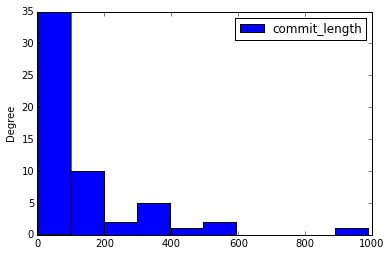

In [17]:
gh_as_json[gh_as_json.type=='CommitCommentEvent'] \
.select(string_length_udf(gh_as_json.payload.comment.body).alias('commit_length'))\
.toPandas()\
.plot(kind='hist')